#### Hypothesis: Players who attempt more three-pointers have a higher field goal percentage.
- This hypothesis suggests that players who attempt more 3 pointers might also have an overall higher field goal percentage.  This can be true in cases where your best shooter on the team will attemmpt the most shots but the relationship may not alwys be direct.  The increased difficulty of three-pointers could lead to a lower field goal percentage, therefore this hypthesis is likely to test whether the number of three-point attempts correlates positively or negatively with field goal percentage and whether there may be a trade-off between shooting the more difficult three-pointers.
#### Research Questiosn:
- Is there a positive correlation between the number of three-point attempts and overall field goal percentage across all players? Across players of certain positions?
- Is the expected value of 3-pointer lower than a 2-pointer?

#### Storypoints
- Court Map
- Hypothesis Testing with Linear Regression: Testing if there is a statistically significant relationship between 3-point attempts and field goal percentage
- Hypothesis Testing with Statistical Tests: Effective Value of 3-Point Shot
- Correlation: Scatter Plots for Shot Quality vs. Field Goals: Plot a scatter plot 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv(r'C:\Users\cneva\Projects\NBA Shot Analysis\Datasets\2023-2024 NBA Player Stats.csv')
# The dataset contains multiple lines for players who were on multiple teams in a season.  There is an additional lines that is the total stats of all teams the player was on with TOT as the team.

In [4]:
df.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Salary'],
      dtype='object')

In [5]:
df1 = (df
       .query("Tm != 'TOT'") # Filter out Total for players with multiple teams
       .query("MP > 7") # Filter out players who have very little game time that might show as outliers
       .assign( # Convert Per game average stats to total stats
           FG = df.G * df.FG,
           FGA = df.G * df.FGA,
           FGPerc = lambda df: df.FG / df.FGA,
           ThreePt = df.G * df['3P'],
           ThreePtA = df.G * df['3PA'],
           ThreePerc = lambda df: df.ThreePt / df.ThreePtA,
           TwoPt = df.G * df['2P'],
           TwoPtA = df.G * df['2PA'],
           TwoPerc = lambda df: df.TwoPt / df.TwoPtA,
           EffectiveFGPerc = lambda df: (df.TwoPt + (1.5 * df.ThreePt)) / df.FGA 
       )
       .loc[:,['Player', 'Tm', 'Pos',
               'FG', 'FGA', 'FGPerc',
               'ThreePt', 'ThreePtA', 'ThreePerc', 
               'TwoPt', 'TwoPtA', 'TwoPerc', 
               'EffectiveFGPerc']]
      )

## 3-Point Attempts vs Field Goal %

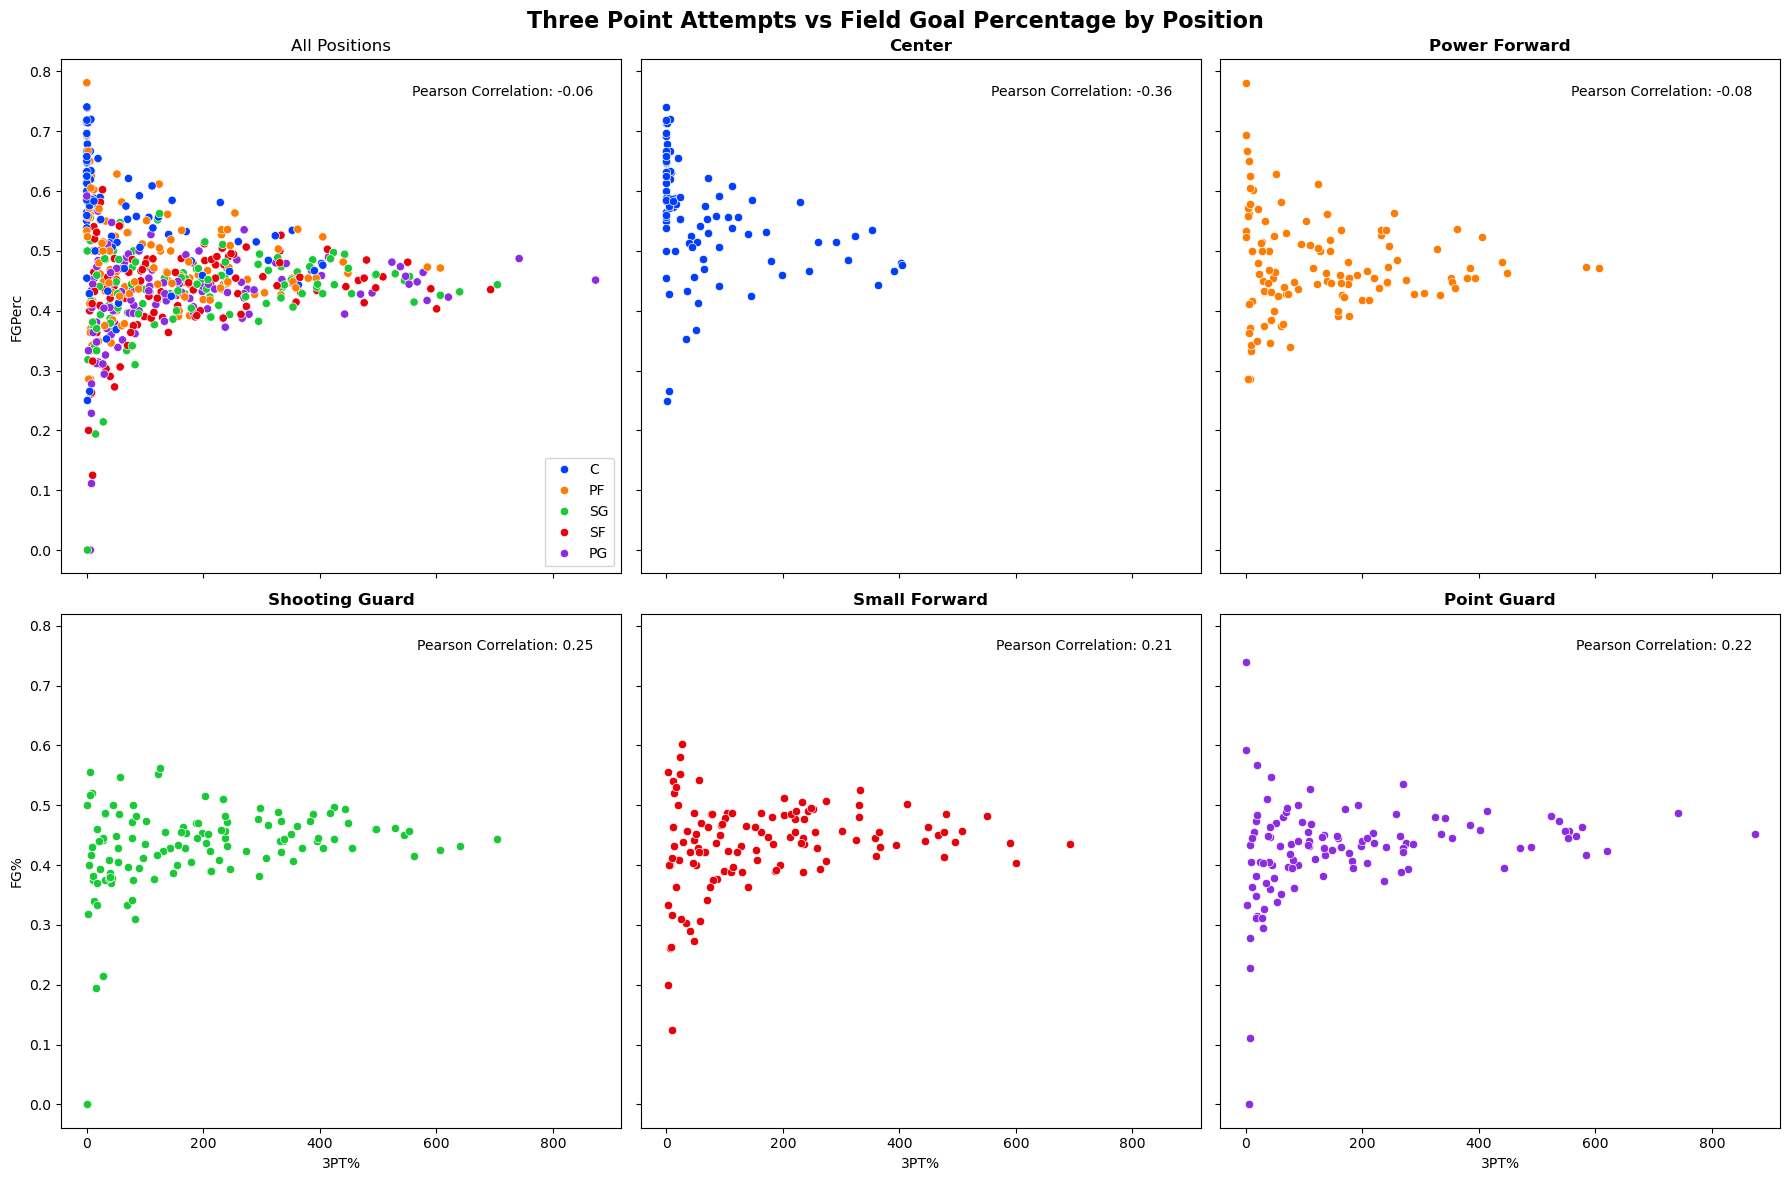

In [7]:
# Three Point Attempts vs Field Goal Percentage by Position (Scatterplot)

# Create a color palette based on the unique positions
positions = df1.Pos.unique()
palette = sns.color_palette("bright", n_colors = len(positions))
position_color_map = {pos: palette[i] for i, pos in enumerate(positions)}

fig, axes = plt.subplots(2, 3, figsize = (18, 12), sharex = True, sharey = True) # Create a subplot with 2 rows/3columns for 1 All position and 5 individual positions

# Plot all positions in the first subplot (top-left)
sns.scatterplot(data = df1, x = 'ThreePtA', y = 'FGPerc', hue = 'Pos', palette = palette, ax = axes[0, 0])
axes[0, 0].set_title('All Positions')
axes[0, 0].legend(loc='lower right', bbox_to_anchor=(1, 0))
correlation_pos = df1.ThreePtA.corr(df1.FGPerc).round(2) # Calculate Pearson Correlation
axes[0, 0].text(0.95, 0.95, f"Pearson Correlation: {correlation_pos:.2f}", ha = 'right', va = 'top', transform = axes[0, 0].transAxes, fontsize = 10)


# Dictionary of position name for converting abbreviations
position_full_names = {
    'PG': 'Point Guard',
    'SG': 'Shooting Guard',
    'SF': 'Small Forward',
    'PF': 'Power Forward',
    'C': 'Center'
}

# For each unique position create a scatterplot filtered on that position
for i, pos in enumerate(positions):
    ax = axes[(i+1)//3, (i+1)%3] # Assign axis
    position_df = df1[df1['Pos'] == pos] # Filter df1 for position
    sns.scatterplot(data = position_df, x = 'ThreePtA', y = 'FGPerc', color = position_color_map[pos], ax = ax) # Plot and color based on position
    
    full_position_name = position_full_names.get(pos, pos) # Convert abbreviated position names to full name
    ax.set_title(f'{full_position_name}', fontweight = 'bold')
    ax.set_xlabel('3PT%')
    ax.set_ylabel('FG%')

    correlation_pos = position_df.ThreePtA.corr(position_df.FGPerc).round(2) # Calculate Pearson Correlation
    ax.text(0.95, 0.95, f"Pearson Correlation: {correlation_pos:.2f}", ha = 'right', va = 'top', transform = ax.transAxes, fontsize = 10)

fig.suptitle('Three Point Attempts vs Field Goal Percentage by Position', fontsize = 16, fontweight = 'bold')
plt.tight_layout()
plt.show()


- Interpretation:
- A value close to 0 suggests no linear relationship
- Even drilled down to position to isolate for a teams best shooters, the data suggest no linear relationship

##### Perform linear regression analysis to formally test the hypothesis and determine if there's a statistically significant relationship between three-point attempts and field goal percentage

In [10]:
import statsmodels.api as sm

X = sm.add_constant(df1.ThreePtA)
y = df1.FGPerc

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 FGPerc   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.288
Date:                Mon, 06 Jan 2025   Prob (F-statistic):              0.131
Time:                        17:24:44   Log-Likelihood:                 537.08
No. Observations:                 554   AIC:                            -1070.
Df Residuals:                     552   BIC:                            -1062.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4666      0.005     85.993      0.0

The p-value of 0.131 is > 0.050 indicating that we cannot reject the null hypothesis that there is no relationship and conclude that the number of 3PT attempts does not significantly affect field goal percentage.

## Expected Value of a Shot

In [13]:
df2 = (df
       .query("MP > 7")
       .loc[:,['Player', 'Tm', 'Pos', 'G',
               'FG', 'FGA',
               '3P', '3PA', 
               '2P', '2PA', ]]
      )
df2.sample(10)

,Player,Tm,Pos,G,FG,FGA,3P,3PA,2P,2PA
285,Scoot Henderson,POR,PG,62,5.0,12.9,1.4,4.3,3.5,8.5
494,Jordan Nwora,IND,SF,18,2.1,4.6,0.6,2.0,1.4,2.6
40,RJ Barrett,TOT,SG,58,7.5,15.2,1.6,4.3,6.0,10.9
543,Trevelin Queen,ORL,SG,14,1.0,2.7,0.2,1.2,0.8,1.5
128,Julian Champagnie,SAS,SF,74,2.2,5.4,1.4,3.7,0.9,1.7
313,Brandon Ingram,NOP,SF,64,7.8,15.9,1.3,3.8,6.5,12.1
368,Saben Lee,PHO,PG,24,0.8,2.3,0.1,0.7,0.8,1.6
402,Tre Mann,OKC,PG,13,1.5,3.1,0.6,1.5,0.9,1.6
66,Onuralp Bitim,CHI,SG,23,1.4,3.7,0.5,1.9,0.9,1.7
212,Markelle Fultz,ORL,PG,43,3.6,7.6,0.1,0.4,3.5,7.2


In [14]:
(df2.assign(
    Three_PT_Total = df2.G * df2['3P'],
    Three_PT_Attempt_Total = df2.G * df2['3PA'],
    Two_PT_Total = df2.G * df2['2P'],
    Two_PT_Attempt_Total = df2.G * df2['2PA']
)
 .iloc[:, 10:]
 .sum().to_frame().T
 .assign(
     Three_PT_Perc = lambda df: df.Three_PT_Total / df.Three_PT_Attempt_Total,
     Two_PT_Perc = lambda df: df.Two_PT_Total / df.Two_PT_Attempt_Total,
     Three_PT_EV = lambda df: df.Three_PT_Perc * 3,
     Two_PT_EV = lambda df: df.Two_PT_Perc * 2,
 )
)

,Three_PT_Total,Three_PT_Attempt_Total,Two_PT_Total,Two_PT_Attempt_Total,Three_PT_Perc,Two_PT_Perc,Three_PT_EV,Two_PT_EV
0,35053.4,96080.1,78882.7,145061.1,0.364835,0.543789,1.094506,1.087579


## Testing Feature Importance

In [16]:
df_shot = pd.read_csv(r'C:\Users\cneva\Projects\NBA Shot Analysis\Datasets\NBA_Shot_Analysis.csv')

## Testing FG% vs Salary

In [17]:
df_plot1 = \
(df_shot \
 .loc[:, ['player_team_name', 'player_name', 'salary', 'position_group', 'shot_made']]
 .groupby(['player_team_name', 'player_name', 'salary', 'position_group']) 
 .agg(
     field_goal_perc = ('shot_made', 'mean'),
     shots_attempted = ('shot_made', 'count')
 )
 .reset_index()
 .assign(
     field_goal_perc = lambda df: df.field_goal_perc.multiply(100).round(1),
     team_total_shots = lambda df: df.groupby('player_team_name')['shots_attempted'].transform('sum'),
     team_shot_perc = lambda df: (df['shots_attempted'] / df['team_total_shots'] * 100).round(1)
 )
 .drop(columns = ['team_total_shots','player_team_name'])
 .query("team_shot_perc > 3") # Filter out players that have < 3% of the teams shots
)

df_plot1.sample(20)

,player_name,salary,position_group,field_goal_perc,shots_attempted,team_shot_perc
106,Darius Garland,34005250,G,44.6,841,11.8
392,Jordan Hawkins,4310196,G,38.2,456,6.4
214,Fred VanVleet,40806300,G,41.6,1018,13.6
365,Jaden McDaniels,3901399,F,48.9,628,9.0
540,Davion Mitchell,5063640,G,45.2,323,4.3
134,Kyrie Irving,38037037,G,49.7,1131,15.4
353,Khris Middleton,29320988,F,49.3,643,8.9
492,Tyrese Maxey,4343920,G,45.0,1419,19.4
600,Pascal Siakam,37893408,F,52.2,623,8.5
208,Aaron Holiday,2346614,G,44.6,417,5.6


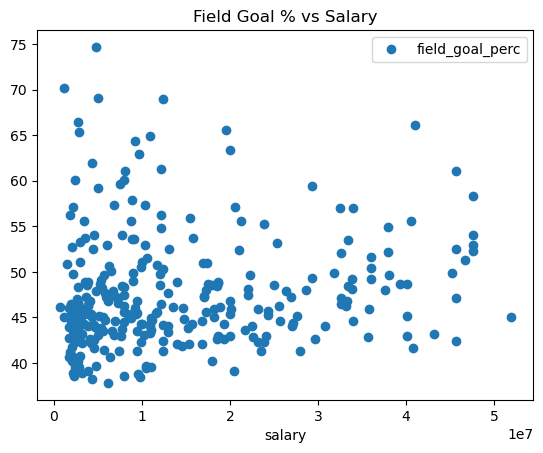

In [18]:
(df_plot1 \
 .plot(
     x = 'salary',
     y = 'field_goal_perc',
     style = 'o',
     title = 'Field Goal % vs Salary',
 )
)

plt.show()

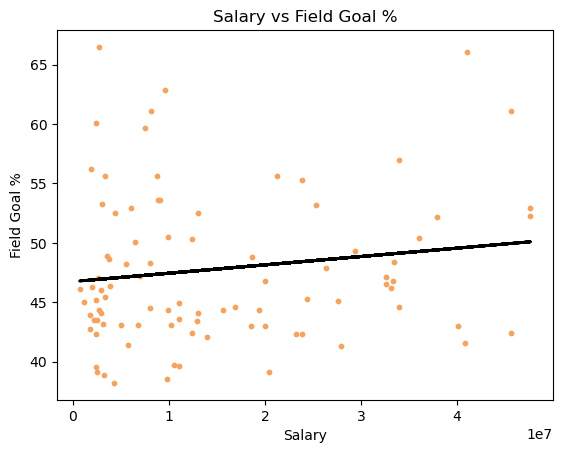

In [19]:
# Testing Hypothesis
X = df_plot1.salary.values.reshape(-1, 1)
y = df_plot1.field_goal_perc.values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

regression = LinearRegression()
regression.fit(X_train, y_train)
y_predicted = regression.predict(X_test)

plt.scatter(X_test, y_test, color = 'sandybrown', s = 10)
plt.plot(X_test, y_predicted, color = 'black', linewidth = 2)
plt.title('Salary vs Field Goal %')
plt.xlabel('Salary')
plt.ylabel('Field Goal %')
plt.show()

In [20]:
# Model Performnace
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)
print('Slope:', regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[7.03585482e-08]]
Mean squared error:  38.83692354025518
R2 score:  0.017040013912507757
